In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
class Model(object):
    def __init__(self, algo, algo_kwargs, weights=[0.1, 0.1], size=100, repeats=200):
        self.algo = algo
        self.algo_kwargs = algo_kwargs
        self.weights = weights
        self.size = size
        self.repeats = repeats
        
    def run_simulation(self):
        """Run a single simulation, recording the performance"""
        algo = self.algo(**self.algo_kwargs)
        arm_choice_record = []
        reward_record = []
        for i in range(self.size):
            arm = algo.choose_arm()
            arm_choice_record.append(arm)
            reward = np.random.random() < self.weights[arm]
            reward_record.append(reward)
            algo.update(arm, reward)
        return arm_choice_record, reward_record
    
    def repeat_simulation(self):
        """Run multiple simulations, recording the performance of each"""
        arm_choice = []
        reward = []
        for i in range(self.repeats):
            arm_choice_record, reward_record = self.run_simulation()
            arm_choice.append(arm_choice_record)
            reward.append(reward_record)
        self.arm_choice = np.array(arm_choice)
        self.reward = np.array(reward)
        
    def plot_arm_frequency(self, ax, color="k"):
        """Plot the frequency with which the second arm is chosen
        NOTE: Currently only works for two arms"""
        ax.plot(self.arm_choice.mean(axis=0), color)
        ax.set_title('Frequency of arm choice')
        ax.set_xlabel('Trial')
        ax.set_ylabel('Frequency')
        return ax
    
    def plot_reward(self, ax, color='-k'):
        """Plot the average reward for each trial across all simulations"""
        ax.plot(self.reward.mean(axis=0), color)
        ax.set_title('Reward')
        ax.set_xlabel('Trial')
        ax.set_ylabel('Reward')
        return ax
    
    def plot_cumulative_reward(self, ax, color='-k'):
        """Plot the cumulative reward across all simulations"""
        ax.plot(np.cumsum(self.reward, axis=1).mean(axis=0), color)
        ax.set_title('Cumulative Reward')
        ax.set_xlabel('Trial')
        ax.set_ylabel('Cumulative Reward')
        return ax

In [3]:
class RCT(object):
    def __init__(self, n_arms, epsilon):
        self._epsilon = epsilon
        self.counts = [0] * n_arms
        self.values = [0] * n_arms
        self.n_arms = n_arms
    
    def choose_arm(self):
        """Choose an arm"""
        if np.random.random() > self.epsilon:
            weights = np.array(self.values)
            weights = weights == weights.max()
            weights = weights / weights.sum()
            return np.random.choice(np.arange(self.n_arms), p=weights)
        else:
            return np.random.randint(self.n_arms)
        
    
    def update(self, arm, reward):
        """Update an arm with the reward"""
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        value = self.values[arm]
        # Running product
        self.values[arm] = ((n - 1) / n) * self.values[arm] + (1/n) * reward
    
    @property
    def epsilon(self):
        if sum(self.counts) < 100:
            return 1
        else:
            return 0

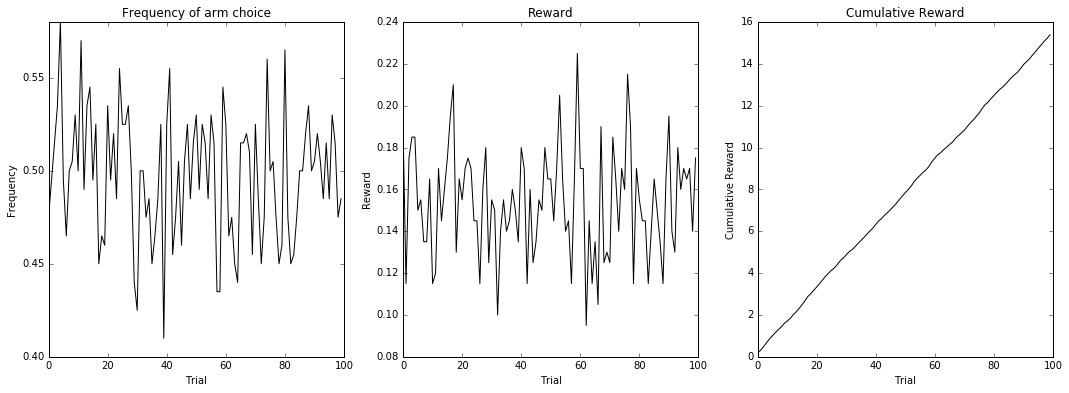

In [4]:
model = Model(RCT, {'n_arms': 2, 'epsilon':0.05}, weights=[0.1, 0.2])
model.repeat_simulation()

fig, axes = plt.subplots(1,3, figsize=(18,6))
model.plot_arm_frequency(ax=axes[0])
model.plot_reward(ax=axes[1])
model.plot_cumulative_reward(ax=axes[2])

plt.show()

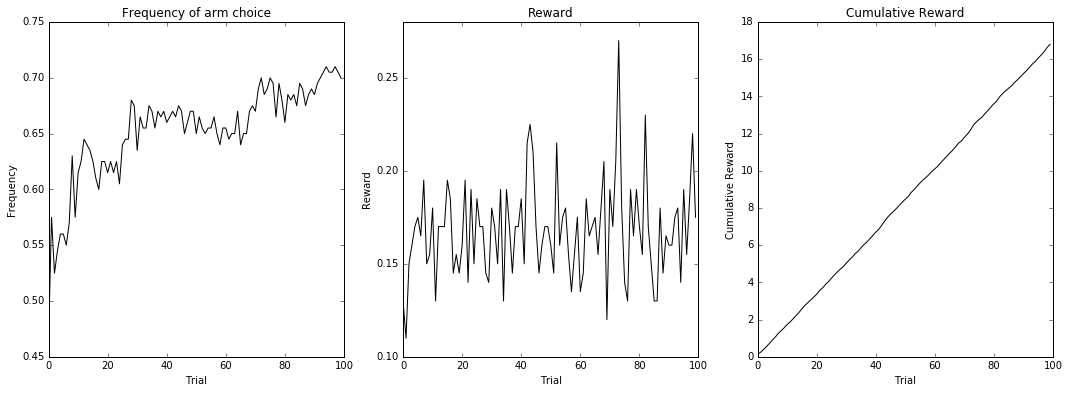

In [4]:
class EpsilonGreedy(RCT):
    
    @property
    def epsilon(self):
        return self._epsilon

model = Model(EpsilonGreedy, {'n_arms': 2, 'epsilon':0.05}, weights=[0.1, 0.2])
model.repeat_simulation()

fig, axes = plt.subplots(1,3, figsize=(18,6))
model.plot_arm_frequency(ax=axes[0])
model.plot_reward(ax=axes[1])
model.plot_cumulative_reward(ax=axes[2])

plt.show()

# Assignments

1. Send in a rough outline of your project idea. This is __not graded__, I will ask for a more complete description later for inclusion in grading.
2. Plot the performance of the RCT and EpsilonGreedy algorithms on the same plots so that they can more easily be compared.
3. Investigate how changing the value of epsilon changes the performance of the EpsilonGreedy algorithm. Reuse your approach from assignment #2 to plot the performance for different epsilon values.
4. When we have very little information on the relative performance of the two arms a high exploration rate quickly provides us with additional information. However, after several hundred trials we are relatively confident in the performance of each arm and a high exploration rate is detrimental as we will be choosing an arm we know to be inferior at a high rate. A better approach would be to reduce the exploration rate as we acquire more information. This is a very similar approach to the simulated annealing optimizer we looked at in week 2. Create a new class that inherits from EpsilonGreedy and gradually reduces the value of epsilon over time.

## Due for next week

1. Rough outline of project idea
2. Plots showing both EpsilonGreedy and RCT performance
3. Plots showing EpsilonGreedy performance with different epsilon values
4. Class implementing EpsilonGreedy with an adaptive epsilon value.

The same code can be used for both #2 and #3 so only #3 will be covered:

* The three plotting methods have been moved into standalone functions. This isn't strictly necessary, but is one approach.
* An extra function has been created combining the three plotting functions.
* Labels and plotting options are used to differentiate between each of the algorithms being plotted.

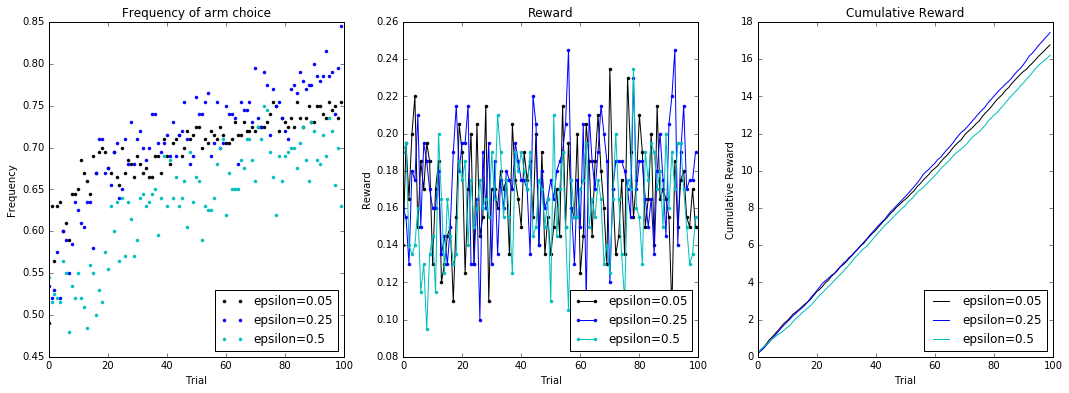

In [5]:
def plot_arm_frequency(simulation, ax, marker='.', linestyle='', color='k', label=''):
    """Plot the frequency with which the second arm is chosen
    NOTE: Currently only works for two arms"""
    ax.plot(simulation.arm_choice.mean(axis=0), 
            marker=marker, linestyle=linestyle, color=color, label=label)
    ax.set_title('Frequency of arm choice')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Frequency')
    return ax
    
def plot_reward(simulation, ax, marker='.', linestyle='-', color='k', label=''):
    """Plot the average reward for each trial across all simulations"""
    ax.plot(simulation.reward.mean(axis=0), 
            marker=marker, linestyle=linestyle, color=color, label=label)
    ax.set_title('Reward')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Reward')
    return ax
    
def plot_cumulative_reward(simulation, ax, marker='', linestyle='-', color='k', label=''):
    """Plot the cumulative reward across all simulations"""
    ax.plot(np.cumsum(simulation.reward, axis=1).mean(axis=0), 
            marker=marker, linestyle=linestyle, color=color, label=label)
    ax.set_title('Cumulative Reward')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Cumulative Reward')
    return ax

def plot_summary(model, axes, color='', label=''):
    plot_arm_frequency(model, ax=axes[0], color=color, label=label)
    plot_reward(model, ax=axes[1], color=color, label=label)
    plot_cumulative_reward(model, ax=axes[2], color=color, label=label)
    for ax in axes:
        ax.legend(loc=4)
    return axes



fig, axes = plt.subplots(1,3, figsize=(18,6))


model = Model(EpsilonGreedy, {'n_arms': 2, 'epsilon':0.05}, weights=[0.1, 0.2])
model.repeat_simulation()
plot_summary(model, axes, color='k', label='epsilon=0.05')


model = Model(EpsilonGreedy, {'n_arms': 2, 'epsilon':0.25}, weights=[0.1, 0.2])
model.repeat_simulation()
plot_summary(model, axes, color='b', label='epsilon=0.25')


model = Model(EpsilonGreedy, {'n_arms': 2, 'epsilon':0.5}, weights=[0.1, 0.2])
model.repeat_simulation()
plot_summary(model, axes, color='c', label='epsilon=0.5')


plt.show()

It appears that the epsilon=0.25 chooses arm 1 more often, and has a higher cumulative reward than the other epsilon values with less and more exploratory tendencies.

The Adaptive Epsilon Greedy algorithm for #4 should change the value of epsilon (and the likelihood of choosing randomly) as the number of trials increase. There are many ways this could be implemented:

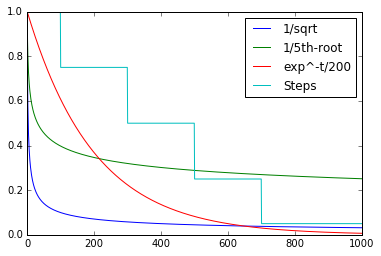

In [12]:
t = np.arange(1000)
plt.plot(t, (1+t)**-0.5, label='1/sqrt')
plt.plot(t, (1+t)**-0.2, label='1/5th-root')
plt.plot(t, np.exp(-(t/200.)), label='exp^-t/200')

u = np.concatenate((np.ones(100), 
                    np.ones(200) * 0.75, 
                    np.ones(200) * 0.5, 
                    np.ones(200) * 0.25,
                    np.ones(300) * 0.05))
plt.plot(t,u, label='Steps')
plt.legend()
plt.show()

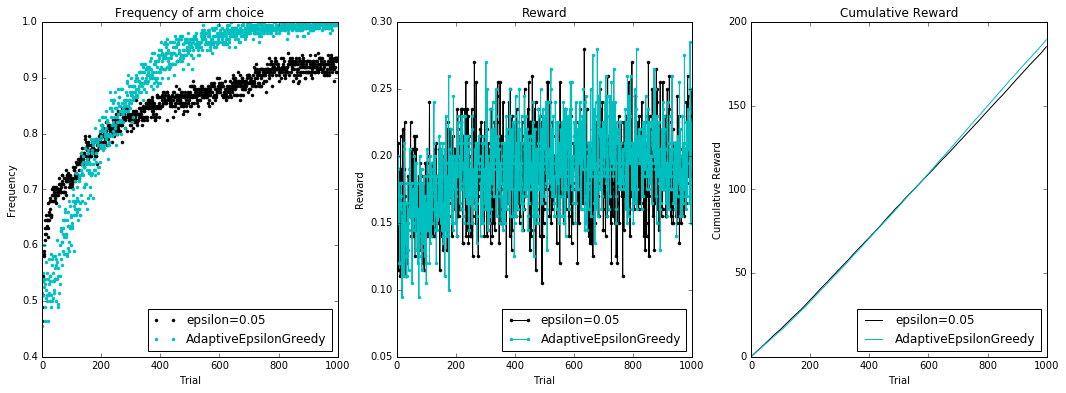

In [7]:
class AdaptiveEpsilonGreedy(RCT):
    
    @property
    def epsilon(self):
        return self._epsilon * np.exp(-(sum(self.counts)/200.))
    
    
    
fig, axes = plt.subplots(1,3, figsize=(18,6))


model = Model(EpsilonGreedy, {'n_arms': 2, 'epsilon':0.05}, weights=[0.1, 0.2], size=1000)
model.repeat_simulation()
plot_summary(model, axes, color='k', label='epsilon=0.05')


model = Model(AdaptiveEpsilonGreedy, {'n_arms': 2, 'epsilon':1.00}, weights=[0.1, 0.2], size=1000)
model.repeat_simulation()
plot_summary(model, axes, color='c', label='AdaptiveEpsilonGreedy')

plt.show()

The falling epsilon value means the AdaptiveEpsilonGreedy algorithm will explore less and less of the time, instead exploiting the arm it knows to be best. This has advantages and disadvantages. If the environment is stable the cumulative reward will be higher but it will be very slow to respond to any changes.

For example, if the rewards for the two arms were to switch:

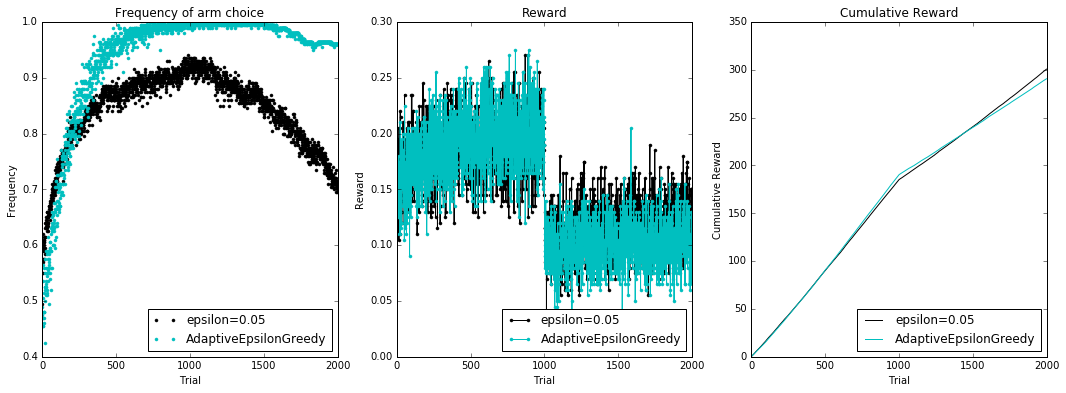

In [13]:
class DynamicModel(object):
    def __init__(self, algo, algo_kwargs, weights=[0.1, 0.1], size=100, repeats=200):
        self.algo = algo
        self.algo_kwargs = algo_kwargs
        self.weights = weights
        self.size = size
        self.repeats = repeats
        
    def run_simulation(self):
        """Run a single simulation, recording the performance"""
        algo = self.algo(**self.algo_kwargs)
        arm_choice_record = []
        reward_record = []
        weights = self.weights[:]
        for i in range(self.size):
            arm = algo.choose_arm()
            arm_choice_record.append(arm)
            reward = np.random.random() < weights[arm]
            reward_record.append(reward)
            algo.update(arm, reward)
            if i == self.size / 2:
                #print('Switching rewards')
                weights[0], weights[1] = weights[1], weights[0]
        return arm_choice_record, reward_record
    
    def repeat_simulation(self):
        """Run multiple simulations, recording the performance of each"""
        arm_choice = []
        reward = []
        for i in range(self.repeats):
            arm_choice_record, reward_record = self.run_simulation()
            arm_choice.append(arm_choice_record)
            reward.append(reward_record)
        self.arm_choice = np.array(arm_choice)
        self.reward = np.array(reward)
        

fig, axes = plt.subplots(1,3, figsize=(18,6))
        
model = DynamicModel(EpsilonGreedy, {'n_arms': 2, 'epsilon':0.05}, weights=[0.1, 0.2], size=2000)
model.repeat_simulation()
plot_summary(model, axes, color='k', label='epsilon=0.05')


model = DynamicModel(AdaptiveEpsilonGreedy, {'n_arms': 2, 'epsilon':1.00}, weights=[0.1, 0.2], size=2000)
model.repeat_simulation()
plot_summary(model, axes, color='c', label='AdaptiveEpsilonGreedy')

plt.show()

There are two reasons why these algorithms are so slow to respond:

* The low exploration rate
* The use of the mean reward values. As the number of trials gets large the ability of any new experiences to alter the mean value falls.

This second issue can be addressed by giving recent experience greater value than experience from further in the past.

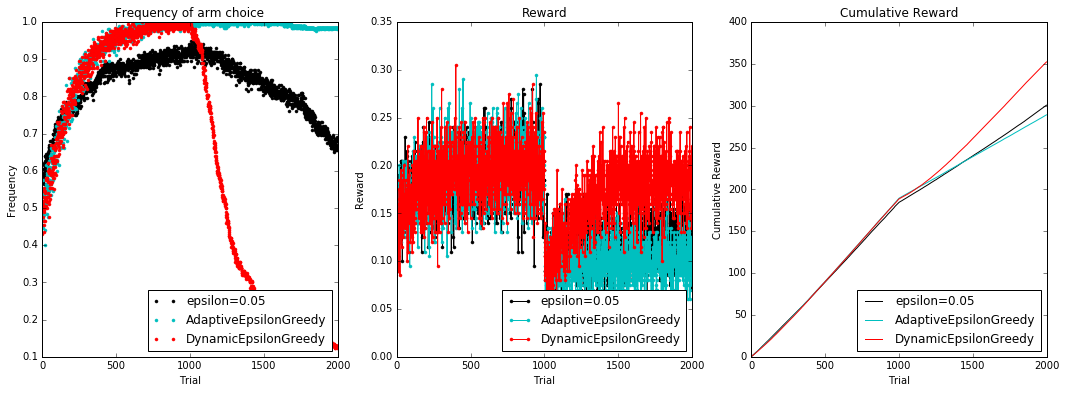

In [14]:
class DynamicEpsilonGreedy(AdaptiveEpsilonGreedy):
    
    def update(self, arm, reward):
        """Update an arm with the reward"""
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        # New experiences will represent at least 100th of the running value estimation
        if n > 100:
            n = 100
        value = self.values[arm]
        self.values[arm] = ((n - 1) / n) * self.values[arm] + (1/n) * reward

    
    
fig, axes = plt.subplots(1,3, figsize=(18,6))
        
model = DynamicModel(EpsilonGreedy, {'n_arms': 2, 'epsilon':0.05}, weights=[0.1, 0.2], size=2000)
model.repeat_simulation()
plot_summary(model, axes, color='k', label='epsilon=0.05')


model = DynamicModel(AdaptiveEpsilonGreedy, {'n_arms': 2, 'epsilon':1.00}, weights=[0.1, 0.2], size=2000)
model.repeat_simulation()
plot_summary(model, axes, color='c', label='AdaptiveEpsilonGreedy')


model = DynamicModel(DynamicEpsilonGreedy, {'n_arms': 2, 'epsilon':1.00}, weights=[0.1, 0.2], size=2000)
model.repeat_simulation()
plot_summary(model, axes, color='r', label='DynamicEpsilonGreedy')

plt.show()